# Compact Convolutional Transformers (10 points)

In this task you will train Vision Transformer-like network for cifar10 images classification.

This task is based on paper [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf)

By implementing all the missing code snippets you can get 10 points. Good luck!


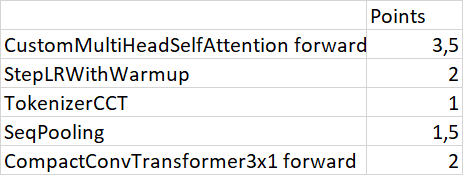

## CIFAR dataset

You have already met this dataset in seminars.

* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [84]:
# when running in colab, un-comment this
!wget https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py

--2022-04-20 19:43:23--  https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py
Resolving cloud.imm.uran.ru (cloud.imm.uran.ru)... 195.19.132.75
Connecting to cloud.imm.uran.ru (cloud.imm.uran.ru)|195.19.132.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182 (2.1K) [text/x-python]
Saving to: ‘cifar.py.4’

cifar.py.4          100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-04-20 19:43:26 (355 MB/s) - ‘cifar.py.4’ saved [2182/2182]



In [85]:
#!L
import numpy as np
import random
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Load data from cifar_data/cifar-10-batches-py/test_batch
(40000, 3, 32, 32) (40000,)


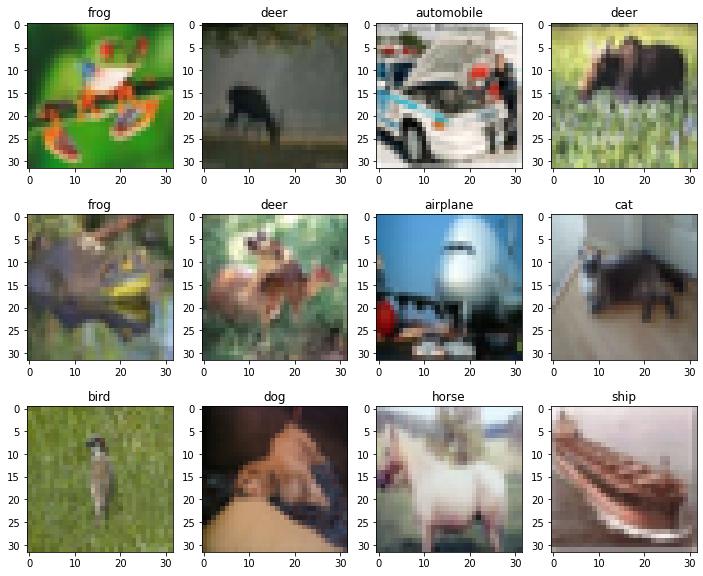

In [86]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
    plt.title(class_names[y_train[i]])

## Prepare dataset and loss

The following code is based on homework 1-pt2 and should be familiar to you.

In [87]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm

In [88]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [89]:
#!L
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean().cpu()

In [90]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2470, 0.2435, 0.2616))

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop((32,32), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [91]:
from torchvision.datasets import CIFAR10

NUM_WORKERS = 16
BATCH_SIZE = 50

train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
val_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Task 1. Multi-head attention

Your turn!

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Let's implement MultiHeadAttention for beggining. It's already implemented in pytorch, so we will use `nn.MultiHeadAttention` for testing of your implementation.

As a reminder, (one-head) attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$, where $d_k$ is size of K


**Tip: read about how the torch.matmul and torch.t methods work. Think about how they will work for batches and what dimension the tensors will have.**

In [92]:
# Complete CustomMultiHeadSelfAttention in modules.py


Let's check that your implementation works like `torch.nn.MultiheadAttention`

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from modules import CustomMultiHeadSelfAttention, StepLRWithWarmup, TokenizerCCT, SeqPooling, create_mlp, DropPath, TransformerEncoder, CompactConvTransformer3x1

In [95]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)

In [96]:
custom_mha = CustomMultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias

In [97]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

for _ in range(100):
    a = torch.rand((1, 10, 128))
    out1 = mha(a, a, a)[0].cpu().detach().numpy()
    out2 = custom_mha(a).cpu().detach().numpy()
    assert np.allclose(out1, out2, atol=1e-6), f"{out1} {out2}"
    
print ("Congratulations! It works!")

Congratulations! It works!


## Task 2: Step-wise learning rate with warm-up

Your task is to implement class that works as `torch.optim.lr_scheduler.StepLR` but supports warm-up.

First of all, examine the docstring and implementation of `StepLR` scheduler:

In [98]:
torch.optim.lr_scheduler.StepLR??

Then implement `get_lr()` method. It should work as following:
1. If `self.last_epoch` is in `[0, self.warmup_epochs)`, then scheduler is in warm-up mode and learning rate should lineary increase during epochs from `self.warmup_lr_init` to `self.base_lrs` (which is the original learning rate of optimizer)
2. If `self.last_epoch` is equal to `self.warmup_epochs`, then just return `self.base_lrs`.
3. If `self.last_epoch - self.warmup_epochs` is not divisible by `self.step_size` then just return the previous learning rate which is available through `[group['lr'] for group in self.optimizer.param_groups]`
4. If `self.last_epoch - self.warmup_epochs` is divisible by `self.step_size` and the current learning rate multiplied by `self.gamma` is not less then self.min_lr, then multiply it and return the new value.
5. Otherwise just return the last learning rate

In [99]:
# Complete class StepLRWithWarmup in modules.py

Let's check what you have written.


All asserts were passed!


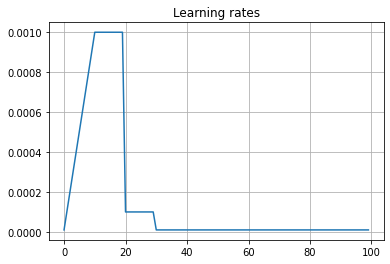

In [100]:
WARMUP_LR_INIT = 1e-5
WARMUP_EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
MIN_LR = 1e-5
OPT_LR = 1e-3

dummy_net = nn.Sequential(nn.Linear(10,10))
dummy_opt = torch.optim.Adam(dummy_net.parameters(), lr=OPT_LR)

scheduler = StepLRWithWarmup(dummy_opt, step_size=STEP_SIZE, gamma=GAMMA, 
                                      warmup_epochs=WARMUP_EPOCHS, warmup_lr_init=WARMUP_LR_INIT,
                                      min_lr=MIN_LR)

# we need to do at least one optimizer step before calling scheduler.step()
# in order to make pytorch happy
dummy_opt.step()  


learning_rates = []
for i in range(100):
    learning_rates.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(learning_rates)
plt.grid()
plt.title('Learning rates')
    
assert np.isclose(learning_rates[0], WARMUP_LR_INIT), \
    f"LR on the first epoch should be equal to {WARMUP_LR_INIT}, actual value {learning_rates[0]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS], OPT_LR), \
    f"LR after warmup shold be equal to {OPT_LR}, actual value {learning_rates[WARMUP_EPOCHS]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE-1], OPT_LR), \
    f"LR after warmup + (STEP_SIZE-1) steps should be equal to {OPT_LR}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE], OPT_LR*GAMMA), \
    f"LR after warmup + (STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1], OPT_LR*GAMMA), \
    f"LR after warmup + (2*STEP_SIZE-1) steps should be equal to {OPT_LR*GAMMA}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+2*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (2*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+2*STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+3*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (3*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+3*STEP_SIZE]}"

for i in range(WARMUP_EPOCHS):
    expected_val = WARMUP_LR_INIT + i*(OPT_LR-WARMUP_LR_INIT) / WARMUP_EPOCHS
    actual_val = learning_rates[i]
    assert np.isclose(actual_val, expected_val), \
        f"LR should linary increase from {WARMUP_LR_INIT} to {OPT_LR} during warmup."\
        f"Expected: {expected_val}, actual: {actual_val}, iteration={i}"
assert all(elem[0] >= MIN_LR for elem in learning_rates)
print("All asserts were passed!")

## Task 3. Compact Convolutional Transformer

During seminar you learned the main components of vision transformer: Tokenizer, Transformer encoder, position embeddings. At this point, it's expected that you have solved the ipython notebook from the seminar. If you didn't, then you know what to do before starting the current task)

Your task is to implement Compact Convolutional Transformer (CCT). It has two main changes comparing to the original ViT that was implemented during seminar. The first one is in tokenizer. Authors of CCT suggested to apply the first convolution with stride=1 allowing transformer to work with input patches that overlaps with each other. Since simple removing of stride increases the spatial resolution of the input tensor, we use MaxPool2d with desired stride in order to reduce the number of tokens.

In [101]:
# Complete class TokenizerCCT in modules.py

The second change is that CCT uses learnable pooling instead of class token for global features extraction. Its formula is similar to attention formula:
$$y = \text{softmax}(WX^T+b) * X$$
where $X$ - layer input - matrix of shape [batch_size, n_tokens, n_embedding], $W$, $b$ - learnable parameters, that transform each token embedding vector to 1 element (in fact it's just a linear layer with output_dim=1).

In [102]:
# Complete class SeqPooling in modules.py

### The following three modules were implemented by you during seminar, so you can just copy-paste their implementations.

MLP for transformer encoder is just a simple two-layer perceptron with GELU as non-linearity. It also uses Dropout after each Linear layer in order to reduce overfitting. Important thing is that size of hidden state on MLP is usually several times bigger than size of MLP input.

In [103]:
# Complete create_mlp function in modules.py

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [104]:
# Complete class DropPath in modules.py

In [105]:
# Complete class TransformerEncoder in modules.py

The final class for the CCT. It looks the same as `VisionTransformer` class in seminar notebook, except the custom tokenizer and pooling. Here we implement a simple version of CCT, whose Tokenizer consist of one convolution of 3x3.

In [106]:
# Complete class CompactConvTransformer3x1 in modules.py

## Final training 

If everything was implemented correctly, the following code will give you a model with > 84.5% accuracy (in fact it should be ~87.5%). If you see a smaller number, check your implementation of modules above.

In [107]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = CompactConvTransformer3x1(input_height=32, input_width=32, n_tokens=16, n_input_channels=3, 
                                  embedding_dim=128, num_layers=4, num_heads=4, num_classes=10, mlp_ratio=2)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = StepLRWithWarmup(opt, 40, gamma=0.3, warmup_epochs=10)

In [ ]:
import time
from tqdm.notebook import tqdm_notebook
num_epochs = 120 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    val_accuracy = []
    
    for X_batch, y_batch in tqdm_notebook(train_batch_gen): # or train_batch_gen
        opt.zero_grad()
        # train on batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = compute_loss(logits, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.numpy())
    print (scheduler.get_last_lr())
    scheduler.step()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in tqdm_notebook(val_batch_gen): # or val_batch_gen
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy) * 100))

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 120 took 106.051s
  training loss (in-iteration): 	2.178670
  validation accuracy: 			25.36 %


  0%|          | 0/1000 [00:00<?, ?it/s]